In [1]:
import sys
sys.path.append('..')
sys.path.append('../..')

In [2]:
import os
from os import path
import torch
from torch.utils.data import DataLoader
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

In [3]:
from Pytorch.utils import Denormalize_tensor

In [4]:
exp_name = "Benedettini-Classification-RN50-SGD"
epochs = 120
batch_size = 56
num_batch_train = 200
num_batch_val = 100
img_size = 280

In [5]:
parameters_path = path.join("parameters", exp_name)
plots_path = path.join("plots", exp_name)

In [6]:
import cv2
from albumentations import Compose, Normalize, VerticalFlip, HorizontalFlip, Rotate, Resize, LongestMaxSize, PadIfNeeded, BboxParams
from albumentations.pytorch import ToTensor
from torch.utils.data import Dataset
import json

def clamp(value, min_value, max_value):
    return max(min(value, max_value), min_value)

class CLASSIFICATION_DATASET(Dataset):
    def __init__(self,
                root_dirpath,
                images_dirpath,
                annotations_path,
                image_id_key="image_id",
                category_id_key="category_id",
                F_image_id_to_relative_path=None,
                augmentation=True,
                desired_size=280,
                batch_size=12,
                num_batch=1):

        self.root_dirpath = root_dirpath
        self.images_dirpath = images_dirpath
        self.annotations_path = annotations_path
        self.image_id_key=image_id_key
        self.category_id_key=category_id_key
        self.F_image_id_to_relative_path = F_image_id_to_relative_path
        self.augmentation = augmentation
        self.desired_size = desired_size
        self.batch_size = batch_size
        self.num_batch = num_batch

        with open(self.annotations_path) as f:
            self.D_instances = json.load(f)
            self.L_annotations = self.D_instances['annotations']
            self.L_categories = self.D_instances['categories']

        # list of real class indices in COCO dataset
        self.L_real_class_idx = [x['id'] for x in self.L_categories]
        # zero-based class indices of COCO dataset (0-79)
        self.L_class_idx = range(len(self.L_real_class_idx))
        # dict to map real class indices to zero-based indices
        self.D_real_class_idx_to_class_idx = { real_class_idx : class_idx for class_idx, real_class_idx in enumerate(self.L_real_class_idx)}

        # dict to map zero based indices to the relative annotations
        self.D_class_to_annotations = self.Create_class_to_annotations_dict()

        # filter zero-based class indices which have no annotations
        self.L_not_empty_class_idx = [class_idx for class_idx in self.L_class_idx if len(self.D_class_to_annotations[class_idx])>0]

        augmentation_transform = Compose(
            [
                VerticalFlip(p=0.5),
                HorizontalFlip(p=0.5),
                LongestMaxSize(max_size=desired_size),
                PadIfNeeded(min_height=desired_size, min_width=desired_size, border_mode=cv2.BORDER_CONSTANT),
                Rotate(p=1.0, limit=90, border_mode=cv2.BORDER_CONSTANT),
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensor(),
            ])

        loading_transform = Compose(
            [
                LongestMaxSize(max_size=desired_size),
                PadIfNeeded(min_height=desired_size, min_width=desired_size, border_mode=cv2.BORDER_CONSTANT),
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensor(),
            ])

        self.transform = augmentation_transform if self.augmentation else loading_transform

    def Create_class_to_annotations_dict(self):
        '''
        Create a dictionary of type (int : list) which map to each zero-based class index a list of
        all the COCO annotations of a specific class using self.D_real_class_idx_to_class_idx as map
        '''
        # init empty dictionary with zero-based class indices
        D_class_to_annotations = {idx : [] for idx in self.L_class_idx}

        for annotation in self.L_annotations:
            real_class_idx = annotation[self.category_id_key]
            class_idx = self.D_real_class_idx_to_class_idx[real_class_idx]
            D_class_to_annotations[class_idx].append(annotation)

        return D_class_to_annotations

    def Get_num_classes(self):
        return len(self.L_categories)

    def Get_class_idx_description(self, class_idx):
        return self.L_categories[class_idx]

    def __getitem__(self, index):
        try:
            # sample a random annotation from a random class
            item_class_idx = np.random.choice(self.L_not_empty_class_idx)
            D_item_annotation = np.random.choice(self.D_class_to_annotations[item_class_idx])

            item_image_id = D_item_annotation[self.image_id_key]

            if(self.F_image_id_to_relative_path):
                image_relative_path = self.F_image_id_to_relative_path(item_image_id)
            else:
                image_relative_path = item_image_id

            item_PIL_image = Image.open(path.join(self.images_dirpath, image_relative_path)).convert('RGB')
            image_width, image_height = item_PIL_image.size

            item_bbox = D_item_annotation['bbox']
            item_bbox[0] = clamp(item_bbox[0], 0, image_width)
            item_bbox[1] = clamp(item_bbox[1], 0, image_height)
            item_bbox[2] = clamp(item_bbox[2], 0, image_width-item_bbox[0])
            item_bbox[3] = clamp(item_bbox[3], 0, image_height-item_bbox[1])

            item_PIL_image_patch = item_PIL_image.crop((item_bbox[0], item_bbox[1], item_bbox[0]+item_bbox[2], item_bbox[1]+item_bbox[3]))
            D_item_transformed = self.transform(image=np.array(item_PIL_image_patch))
            return (D_item_transformed["image"],), item_class_idx
        except:
            return self[0]

    def __len__(self):
        return self.num_batch*self.batch_size

In [7]:
DSET_training = CLASSIFICATION_DATASET(
    root_dirpath = '../../../Datasets/Points Of Interest Recognition/Monastero dei Benedettini/',
    images_dirpath = '../../../Datasets/Points Of Interest Recognition/Monastero dei Benedettini/',
    annotations_path = '../../../Datasets/Points Of Interest Recognition/Monastero dei Benedettini/train_dataset.json',
    image_id_key="path",
    category_id_key="class_id",
    augmentation=True,
    batch_size=batch_size,
    num_batch=num_batch_train,
    desired_size=img_size,
)

In [8]:
DSET_validation = CLASSIFICATION_DATASET(
    root_dirpath = '../../../Datasets/Points Of Interest Recognition/Monastero dei Benedettini/',
    images_dirpath = '../../../Datasets/Points Of Interest Recognition/Monastero dei Benedettini/',
    annotations_path = '../../../Datasets/Points Of Interest Recognition/Monastero dei Benedettini/val_dataset.json',
    image_id_key="path",
    category_id_key="class_id",
    augmentation=False,
    batch_size=batch_size,
    num_batch=num_batch_val,
    desired_size=img_size,
)

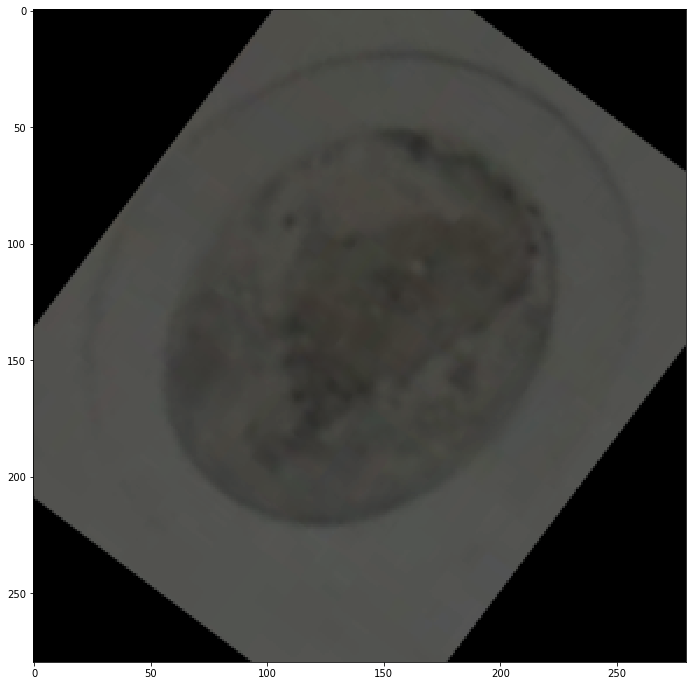

{'id': 14, 'name': '6.5_BassorilieviMancanti'}

In [9]:
(T_img, ), class_idx = DSET_training[0]
denormalize_func = Denormalize_tensor(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
T_normal_img = denormalize_func(T_img)
plt.figure(figsize=(12, 12))
plt.imshow(transforms.ToPILImage()(T_normal_img))
plt.show()
DSET_training.Get_class_idx_description(class_idx)

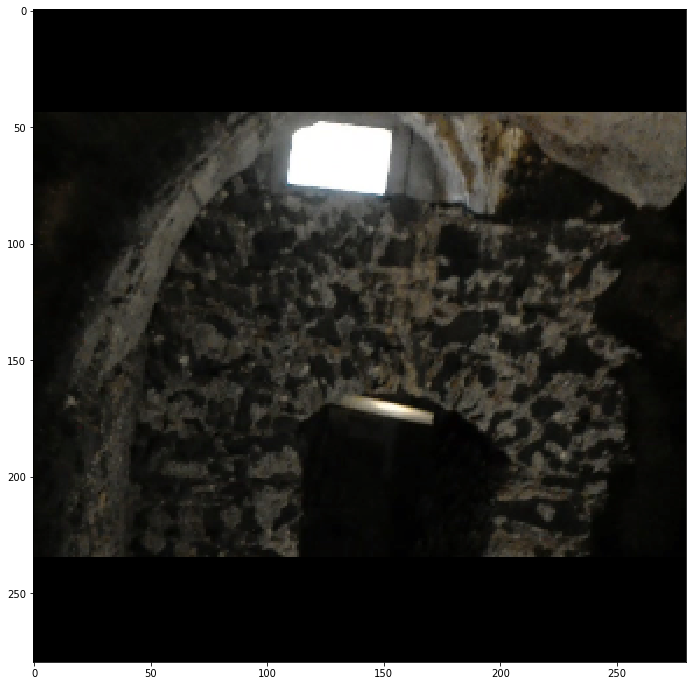

{'id': 27, 'name': '8.2_VanoRaccoltaCenere'}

In [10]:
(T_img, ), class_idx = DSET_validation[0]
denormalize_func = Denormalize_tensor(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
T_normal_img = denormalize_func(T_img)
plt.figure(figsize=(12, 12))
plt.imshow(transforms.ToPILImage()(T_normal_img))
plt.show()
DSET_validation.Get_class_idx_description(class_idx)

In [11]:
DL_training = DataLoader(DSET_training, batch_size=batch_size, shuffle=False)
DL_validation = DataLoader(DSET_validation, batch_size=batch_size, shuffle=False)

In [12]:
from torchvision.models import resnet50

class M_CLASSIFIER(torch.nn.Module):
    def __init__(self, num_classes):
        super(M_CLASSIFIER, self).__init__()
        self.num_classes = num_classes
        self.M_backbone = resnet50(pretrained=True)
        self.M_backbone.fc = torch.nn.Linear(
            in_features = self.M_backbone.fc.in_features, 
            out_features = num_classes,
            bias=True
        )
        
    def forward(self, inputs):
        (T_image,) = inputs
        return self.M_backbone(T_image)
        
M_classifier = M_CLASSIFIER(DSET_training.Get_num_classes())
M_classifier = M_classifier.to("cuda")

In [13]:
def prepare_batch_fn(batch, gt):
    gt = gt.long()
    return batch, gt

In [14]:
optimizer = torch.optim.SGD(M_classifier.parameters(), lr = 0.1, momentum = 0.12)
criterion = torch.nn.CrossEntropyLoss()

In [15]:
from torchtrainer.trainer import Trainer, Mode
from torchtrainer.callbacks.calculate_accuracy_callback import CalculateTopNAccuracyCallback
from torchtrainer.callbacks.calculate_loss_callback import CalculateLossCallback
from torchtrainer.callbacks.plot_callback import PlotCallback
from torchtrainer.callbacks.save_parameters_callback import SaveParametersCallback
from torchtrainer.callbacks.set_tqdm_bar_description_callback import SetTQDMBarDescriptionCallback
from torchtrainer.callbacks.lr_batch_scheduler_callback import LRBatchSchedulerCallBack
from torchtrainer.callbacks.calculate_accuracy_per_class_callback import CalculateAccuracyPerClassCallback
from torchtrainer.callbacks.plot_accuracy_per_class_callback import PlotAccuracyPerClassCallback

In [18]:
trainer = Trainer(
    device = 'cuda',
    modes = [Mode.TRAIN, Mode.EVALUATE],
    model = M_classifier,
    data_loaders = {Mode.TRAIN : DL_training, Mode.EVALUATE : DL_validation},
    epochs = epochs,
    starting_epoch = 0,
    optimizer = optimizer,
    criterion = criterion,
    prepare_batch_fn = prepare_batch_fn,
    callbacks = [
        CalculateLossCallback(key='Loss'),
        CalculateTopNAccuracyCallback(keys=('Top-1 accuracy',), topk=(1,)),
        CalculateAccuracyPerClassCallback(DSET_training.Get_num_classes()),
        PlotCallback(plots_path, labels_map={Mode.TRAIN:"Train", Mode.EVALUATE:"Val"}, columns=['Loss', 'Top-1 accuracy']),
        PlotAccuracyPerClassCallback(DSET_training.Get_num_classes(), plots_path),
        SetTQDMBarDescriptionCallback(keys=['Loss', 'Top-1 accuracy']),
        SaveParametersCallback(parameters_path),
    ]
)

In [19]:
trainer.start()

Epoch 0


Loss = 4.6370 Top-1 accuracy = 9.8214 : 100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


Epoch 1


Loss = 3.6827 Top-1 accuracy = 21.4286 : 100%|██████████| 4/4 [00:07<00:00,  1.79s/it]


Epoch 2


Loss = 2.4215 Top-1 accuracy = 41.9643 : 100%|██████████| 4/4 [00:07<00:00,  1.90s/it]


Epoch 3


Loss = 2.0648 Top-1 accuracy = 45.9821 : 100%|██████████| 4/4 [00:06<00:00,  1.74s/it]


Epoch 4


Loss = 1.8488 Top-1 accuracy = 50.4464 : 100%|██████████| 4/4 [00:06<00:00,  1.70s/it]


Epoch 5


Loss = 2.3425 Top-1 accuracy = 41.0714 : 100%|██████████| 4/4 [00:06<00:00,  1.68s/it]


Epoch 6


Loss = 2.1685 Top-1 accuracy = 53.1250 : 100%|██████████| 4/4 [00:06<00:00,  1.59s/it]


Epoch 7


Loss = 1.4554 Top-1 accuracy = 59.3750 : 100%|██████████| 4/4 [00:06<00:00,  1.66s/it]


Epoch 8


Loss = 1.3580 Top-1 accuracy = 62.5000 : 100%|██████████| 4/4 [00:06<00:00,  1.69s/it]


Epoch 9


Loss = 0.2668 Top-1 accuracy = 91.5179 :  67%|██████▋   | 4/6 [00:13<00:06,  3.42s/it]

KeyboardInterrupt: 

In [ ]:
from torch_lr_finder import LRFinder

In [ ]:
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
optimizer = torch.optim.SGD(M_classifier.parameters(), lr=1e-7, momentum=0.0)
lr_finder = LRFinder(M_classifier, optimizer, criterion, device="cuda")
lr_finder.range_test(DL_training, end_lr=2, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [ ]:
optimizer = torch.optim.SGD(M_classifier.parameters(), lr=1e-7, momentum=0.2)
lr_finder = LRFinder(M_classifier, optimizer, criterion, device="cuda")
lr_finder.range_test(DL_training, end_lr=2, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [ ]:
optimizer = torch.optim.SGD(M_classifier.parameters(), lr=1e-7, momentum=0.6)
lr_finder = LRFinder(M_classifier, optimizer, criterion, device="cuda")
lr_finder.range_test(DL_training, end_lr=2, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state